In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm import tqdm
from IPython import display
print('Tensorflow version : ', tf.__version__)


Tensorflow version :  2.16.2


In [21]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=((x_train.astype(np.float32)/255.0)*2.0 - 1.0)[..., np.newaxis]
x_test=((x_test.astype(np.float32)/255.0)*2.0 - 1.0)[..., np.newaxis]
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

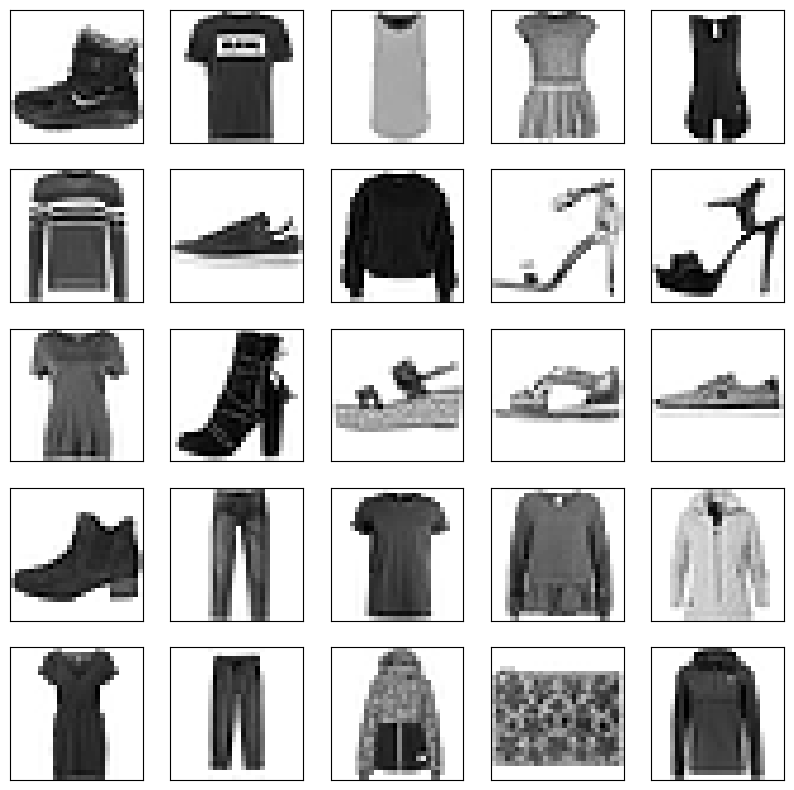

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(((x_train[i]+1.0)/2.0).squeeze(-1),cmap=plt.cm.binary)
plt.show()

training parameters defining 

In [23]:
batch_size=32 
def create_batch(x_train):
    dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
    dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

    return dataset 


In [25]:
num_features=1000 

generator=keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding="same", activation="selu"
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding="same", activation="tanh"
    ),
])

generator.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │     6,278,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,485,505 (24.74 MB)

 Trainable params: 6,485,121 (24.74 MB)

 Non-trainable params: 384 (1.50 KB)

In [26]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

discriminator.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile discriminator standalone
discriminator.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# When training the combined model, freeze discriminator weights
discriminator.trainable = False

# Combined GAN: generator feeding into the frozen discriminator
gan = keras.models.Sequential([generator, discriminator])
gan.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
)


In [32]:
from tqdm.notebook import tqdm  

epochs = 10   

dataset = create_batch(x_train)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for real_images in tqdm(dataset, leave=False):
        batch_size_curr = int(real_images.shape[0])
        noise = tf.random.normal([batch_size_curr, num_features])
        fake_images = generator(noise, training=True)

        # Train discriminator on real and fake
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, tf.ones((batch_size_curr, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, tf.zeros((batch_size_curr, 1)))

        # Train generator via the frozen discriminator
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, tf.ones((batch_size_curr, 1)))

    print(f"D loss real: {d_loss_real} | D loss fake: {d_loss_fake} | G loss: {g_loss}")



Epoch 1/10


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [33]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
